In [1]:
import os 
import torch 
import torch.nn as nn 
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import time 
from torchvision.utils import save_image
from torch.utils.data import Dataset
from  torchinfo import summary 
import torchsummary

c:\Users\sim2real\AppData\Local\miniconda3\envs\fish\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# setting 
EPOCHS = 200 
BATCH_SIZE = 100 
LEARNING_RATE = 0.0002
IMAGE_SIZE = 28
IMAGE_CHANNEL = 1 
LATENT_DIM = 100 # 28*28 = 784가 아닌데?

DIRECTORY_NAME = "./VanillaGAN_Result"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device {DEVICE}")
# Result Directory 
if not os.path.exists(DIRECTORY_NAME):
    os.makedirs(DIRECTORY_NAME)

Using Device cuda


# Discriminator 

- input : (BATCH,IMAGE_CHANNEL,IMAGE_SIZE,IMAGE_SIZE)
- output : (BATCH,1)

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        self.model = nn.Sequential(
            nn.Linear(IMAGE_CHANNEL* IMAGE_SIZE*IMAGE_SIZE,512),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1), # []
            nn.Sigmoid(),
        )
    def forward(self,img):
        flattend = img.view(img.size(0),-1)
        output = self.model(flattend)
        return output 

discriminator = Discriminator().to(DEVICE)
summary(discriminator,input_size=(BATCH_SIZE,IMAGE_CHANNEL,IMAGE_SIZE,IMAGE_SIZE))


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [100, 1]                  --
├─Sequential: 1-1                        [100, 1]                  --
│    └─Linear: 2-1                       [100, 512]                401,920
│    └─LeakyReLU: 2-2                    [100, 512]                --
│    └─Linear: 2-3                       [100, 256]                131,328
│    └─LeakyReLU: 2-4                    [100, 256]                --
│    └─Linear: 2-5                       [100, 1]                  257
│    └─Sigmoid: 2-6                      [100, 1]                  --
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
Total mult-adds (M): 53.35
Input size (MB): 0.31
Forward/backward pass size (MB): 0.62
Params size (MB): 2.13
Estimated Total Size (MB): 3.06

In [4]:
torchsummary.summary(discriminator,(IMAGE_CHANNEL,IMAGE_SIZE,IMAGE_SIZE))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
         LeakyReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 256]         131,328
         LeakyReLU-4                  [-1, 256]               0
            Linear-5                    [-1, 1]             257
           Sigmoid-6                    [-1, 1]               0
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.04
Estimated Total Size (MB): 2.05
----------------------------------------------------------------


# Generator 

- input : (BATCH,LATENT_DIM)
- output : (BATCH,IMAGE_CHANNEL,IMAGE_SIZE,IMAGE_SIZE)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()

        self.model = nn.Sequential(
            nn.Linear(LATENT_DIM,128), # 100,100 -==
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(128,256),
            nn.BatchNorm1d(256,0.8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(256,512),
            nn.BatchNorm1d(512,0.8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(512,1024),
            nn.BatchNorm1d(1024,0.8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(1024,IMAGE_CHANNEL*IMAGE_SIZE*IMAGE_SIZE),
            nn.Tanh()
        )

    def forward(self,z):
        img = self.model(z)
        img = img.view(img.size(0),1,28,28)
        return img 

generator = Generator().to(DEVICE)
summary(generator,input_size=(BATCH_SIZE,LATENT_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [100, 1, 28, 28]          --
├─Sequential: 1-1                        [100, 784]                --
│    └─Linear: 2-1                       [100, 128]                12,928
│    └─LeakyReLU: 2-2                    [100, 128]                --
│    └─Linear: 2-3                       [100, 256]                33,024
│    └─BatchNorm1d: 2-4                  [100, 256]                512
│    └─LeakyReLU: 2-5                    [100, 256]                --
│    └─Linear: 2-6                       [100, 512]                131,584
│    └─BatchNorm1d: 2-7                  [100, 512]                1,024
│    └─LeakyReLU: 2-8                    [100, 512]                --
│    └─Linear: 2-9                       [100, 1024]               525,312
│    └─BatchNorm1d: 2-10                 [100, 1024]               2,048
│    └─LeakyReLU: 2-11                   [100, 1024]        

# DATASET 

Train data path: ./dataset/Fashion-MNIST/fashion-mnist_train.csv
Valid data path: ./dataset/Fashion-MNIST/fashion-mnist_test.csv
Image size: (60000, 28, 28)
--- Label ---
label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64
<PIL.Image.Image image mode=L size=28x28 at 0x20DD5998A30>
Ankle boot


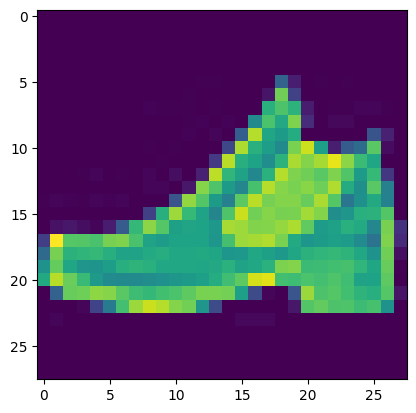

In [6]:
%matplotlib inline
from matplotlib.pyplot import imshow

import pandas as pd
import numpy as np
from PIL import Image

train_data_path = './dataset/Fashion-MNIST/fashion-mnist_train.csv' # Path of data
valid_data_path = './dataset/Fashion-MNIST/fashion-mnist_test.csv' # Path of data
print('Train data path:', train_data_path)
print('Valid data path:', valid_data_path)

class_list = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_num = len(class_list)

transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


class FashionMNIST(Dataset):
    def __init__(self, path, img_size, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv(path)
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, img_size, img_size)
        self.labels = fashion_df.label.values
        print('Image size:', self.images.shape)
        print('--- Label ---')
        print(fashion_df.label.value_counts())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.images[idx]
        img = Image.fromarray(self.images[idx])
            
        if self.transform:
            img = self.transform(img)
        
        return img, label
    


dataset = FashionMNIST(train_data_path, IMAGE_SIZE,transform=None)
imshow(dataset[1][0])
print(dataset[1][0])
print(class_list[dataset[1][1]])


In [7]:

dataset = FashionMNIST(train_data_path,IMAGE_SIZE,transform=transforms_train)
data_loader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True)

Image size: (60000, 28, 28)
--- Label ---
label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64


In [8]:
len(data_loader) # 데이터 총 수량 / BATSIZE

600

In [9]:
adversarial_loss = nn.BCELoss()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)

In [10]:
# GAN 
start_time = time.time()
for epoch in range(EPOCHS):
    #print('Starting epoch {}...'.format(epoch+1))
    for i,(images,_) in enumerate(data_loader):
        real_imgs = images.to(DEVICE)
        
        discriminator_label = torch.ones(BATCH_SIZE).unsqueeze(1).to(DEVICE)
        generator_label = torch.zeros(BATCH_SIZE).unsqueeze(1).to(DEVICE)
        

        d_optimizer.zero_grad()
        latent = torch.normal(mean=0,std=1,size=(BATCH_SIZE,LATENT_DIM)).to(DEVICE)
        fake_images = generator(latent)
        d_loss = adversarial_loss(discriminator(real_imgs),discriminator_label)
        g_loss = adversarial_loss(discriminator(fake_images.detach()),generator_label)

        t_loss = (d_loss + g_loss) /2
        t_loss.backward()
        d_optimizer.step()


        g_optimizer.zero_grad()
        fake_images = generator(latent)
        g_loss = adversarial_loss(discriminator(fake_images),discriminator_label)
        g_loss.backward()
        g_optimizer.step()

        done = epoch* len(data_loader)+i
        if done % 12000 == 0:
            save_image(fake_images.data[:9],f"{DIRECTORY_NAME}/{epoch}_epoch.png",nrow = 3,normalize = True)

    print(f"[Epoch {epoch}/{EPOCHS}] [D loss:{t_loss.item():.6f}] \
        [G loss: {g_loss.item():.6f}] \
        [Elapsed time: {time.time() - start_time:.2f}s]")






[Epoch 0/200] [D loss:0.379486]         [G loss: 2.136411]         [Elapsed time: 12.60s]
[Epoch 1/200] [D loss:0.096349]         [G loss: 4.374273]         [Elapsed time: 25.40s]
[Epoch 2/200] [D loss:0.017351]         [G loss: 9.176032]         [Elapsed time: 37.90s]
[Epoch 3/200] [D loss:0.025360]         [G loss: 10.052016]         [Elapsed time: 50.52s]
[Epoch 4/200] [D loss:0.118798]         [G loss: 5.993961]         [Elapsed time: 63.21s]
[Epoch 5/200] [D loss:0.140056]         [G loss: 9.236523]         [Elapsed time: 75.74s]
[Epoch 6/200] [D loss:0.029998]         [G loss: 7.728452]         [Elapsed time: 88.19s]
[Epoch 7/200] [D loss:0.140664]         [G loss: 5.843629]         [Elapsed time: 100.59s]
[Epoch 8/200] [D loss:0.102927]         [G loss: 7.308156]         [Elapsed time: 113.08s]
[Epoch 9/200] [D loss:0.078909]         [G loss: 6.148420]         [Elapsed time: 125.73s]
[Epoch 10/200] [D loss:0.188452]         [G loss: 5.925086]         [Elapsed time: 138.36s]
[Epo

In [11]:
# cGAN 
# for epoch in range(EPOCHS):
#     print('Starting epoch {}...'.format(epoch+1))
#     for i,(images,labels) in enumerate(data_loader):
#         real_imgs = images.to(DEVICE)
#         real_labels = labels.to(DEVICE)

#         discriminator_label = torch.cuda.FloatTensor(BATCH_SIZE,1).fill_(1.0)
#         generator_label =torch.cuda.FloatTensor(BATCH_SIZE,1).fill_(0.0)
#         # discriminator Train 
#         d_optimizer.zero_grad()
#         real_validity = discriminator(real_imgs,real_labels)
#         D_loss = adversarial_loss(real_validity,discriminator_label)

#         latent_vector = torch.normal(mean = 0,std =1,size=(BATCH_SIZE,LATENT_DIM)).to(DEVICE)
#         fake_labels = torch.LongTensor(np.random.randint(0,class_num,BATCH_SIZE)).to(DEVICE)

#         fake_images = generator(latent_vector,fake_labels)

#         # generator Train 
#         g_optimizer.zero_grad()

